# Pathology using Log-log Models for Pricing Optimization

The log-log approach is sometimes used to model the elasticity curve between 

- demand/quantity (y-axis) and
- price (x-axis)

since the relationship is curvilinear. Let's see how the log-log approach might break down.

## Simulation

First, let's simulate the relationship between quantity, $Q$, and price, $P$, as an exponential decay. Once we have $Q$ and $P$, we can compute other quantities of interest.

- $P$ is price
- $Q$ is quantity
- $R = PQ$ is the revenue
- $R' = \dfrac{\mathrm{d}R}{\mathrm{d}Q}$ is the marginal revenue (MR)
- $C'$ is the marginal cost (MC) (usually given)
- $C = C'Q$ is the total cost
- $T = PQ - C'Q = R - C$ is the profit

All relationships are modeled using a nonlinear GAM model.

In [1]:
import numpy as np
import pandas as pd
from pygam import LinearGAM, s, f
import numdifftools as nd

np.random.seed(37)

def get_elasticity_curve(N_0=1, decay_rate=-0.05, n=1_000, start=0, end=100, std=0.01):
    x = np.linspace(start, end, n)
    y = (N_0 * np.exp(decay_rate * x)) + np.random.normal(0, std, len(x))

    return pd.Series(y, x)

def get_elasticity_curve_df(N_0=1, decay_rate=-0.05, n=1_000, start=0, end=100, std=0.01):
    return get_elasticity_curve(N_0, decay_rate, n, start, end, std) \
        .to_frame() \
        .reset_index() \
        .rename(columns={
            'index': 'P', 
            0: 'Q'
        })

def predict(X_col, y_col, df):
    X = df[[X_col]]
    y = df[y_col]

    m = LinearGAM(s(0, n_splines=10)).fit(X, y)
    y_pred = m.predict(X)
    return y_pred

def gradient(X_col, y_col, df):
    X = df[[X_col]]
    y = df[y_col]

    m = LinearGAM(s(0, n_splines=10)).fit(X, y)

    dfun = nd.Gradient(lambda x: m.predict(pd.DataFrame(x.reshape(-1,1), columns=[X_col])))
    g = np.array([dfun(v) for v in df[X_col].values])
    return g

df = get_elasticity_curve_df(N_0=500, std=10) \
    .assign(R=lambda d: d['P'] * d['Q']) \
    .assign(Q=lambda d: predict('P', 'Q', d)) \
    .assign(R=lambda d: predict('Q', 'R', d)) \
    .assign(MR=lambda d: gradient('Q', 'R', d)) \
    .assign(MC=20) \
    .assign(C=lambda d: d['MC'] * d['Q']) \
    .assign(T=lambda d: d['R'] - d['C'])

df.shape

(1000, 7)

Here's a snippet of the generated data and computed quantities of interest.

In [2]:
df.head()

,P,Q,R,MR,MC,C,T
0,0.0000,487.419548,64.537364,-21.054663,20,9748.390965,-9683.853601
1,0.1001,485.448437,107.587847,-21.034341,20,9708.968743,-9601.380897
2,0.2002,483.479636,150.519794,-21.010817,20,9669.592713,-9519.072919
3,0.3003,481.513178,193.325716,-20.984101,20,9630.263558,-9436.937841
4,0.4004,479.549098,235.998177,-20.954207,20,9590.981962,-9354.983784


We can find the optimal price when $C'$ and close to or equals $R'$. For this example, $C'=20$ and so the optimal price is $P=37.94$.

In [3]:
opt_s = df \
    .assign(diff=lambda d: np.abs(d['MC'] - d['MR'])) \
    .sort_values(['diff']) \
    .head(1) \
    .iloc[0]
opt_s

P         37.937938
Q         75.346963
R       2906.723312
MR        20.061433
MC        20.000000
C       1506.939264
T       1399.784048
diff       0.061433
Name: 379, dtype: float64

Let's now plot $P$ against $Q, R,$ and $T$.

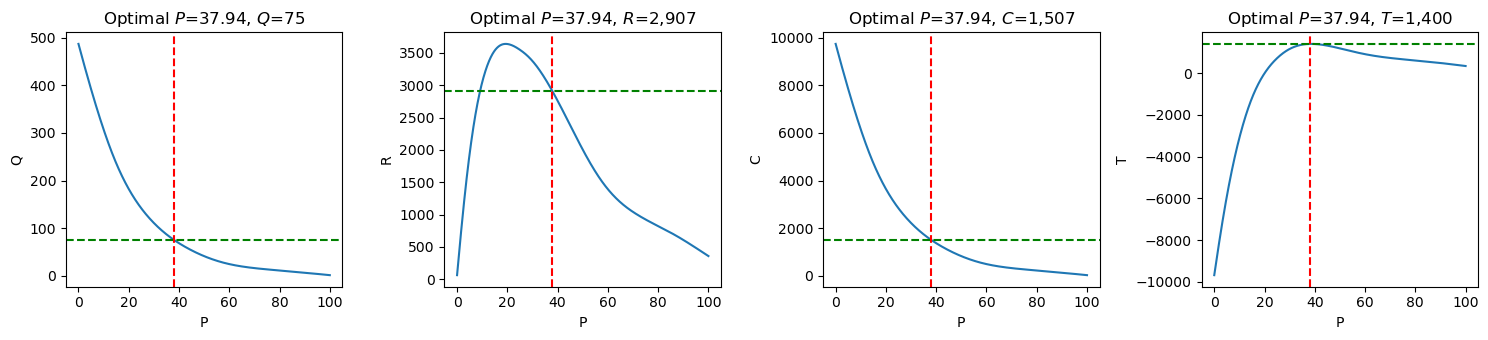

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 4, figsize=(15, 3.5))

for y, _ax in zip(['Q', 'R', 'C', 'T'], ax):
    df.plot(kind='line', x='P', y=y, ax=_ax)
    _ax.axvline(x=opt_s['P'], color='r', linestyle='--')
    _ax.axhline(y=opt_s[y], color='g', linestyle='--')
    _ax.set_ylabel(y)
    _ax.set_title(rf'Optimal $P$={opt_s["P"]:.2f}, ${y}$={opt_s[y]:,.0f}')
    _ax.legend().remove()

fig.tight_layout()

<Axes: xlabel='Q'>

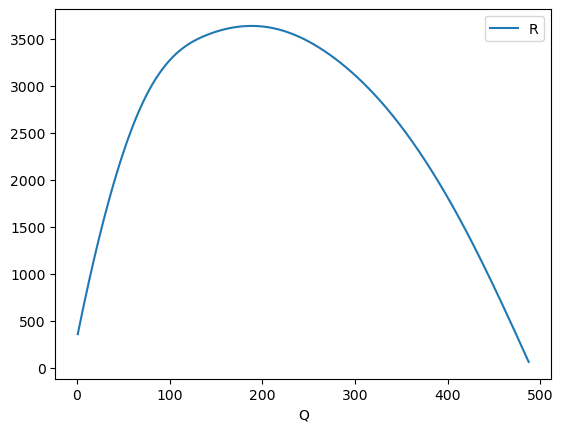

In [69]:
df.plot(kind='line', x='Q', y='R')

## Linear modeling

Let's model the relationship between $P$ and $Q$ using a linear model.

In [5]:
from sklearn.linear_model import LinearRegression

X = df[['P']]
y = df['Q']

m = LinearRegression().fit(X, y)
y_pred = m.predict(X)

_lin_df = X.assign(Q=y_pred)

## Log-log modeling

Let's model the $P$ and $Q$ relationship using a log-log model.

In [6]:
X = np.log(df[['P']] + 0.01)
y = np.log(df['Q'])

m = LinearRegression().fit(X, y)
y_pred = m.predict(X)

_log_df = X.assign(Q=y_pred)

## Visualizing linear models

In the graphs below, the linear models create a straight line. You can see that at the extremes (far left and far right), the linear models underestimates $Q$ based on $P$.

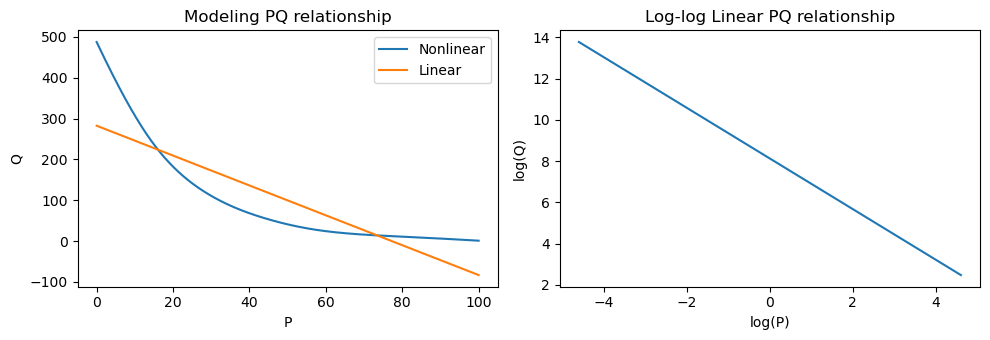

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3.5))

df.plot(kind='line', x='P', y='Q', ylabel='Q', ax=ax[0], label='Nonlinear')
_lin_df.plot(kind='line', x='P', y='Q', ax=ax[0], label='Linear')
_log_df.plot(kind='line', x='P', y='Q', ax=ax[1], xlabel='log(P)', ylabel='log(Q)')

ax[0].set_title('Modeling PQ relationship')
ax[1].set_title('Log-log Linear PQ relationship')
ax[1].legend().remove()

fig.tight_layout()

## Optimizing price based on the log-log model

Let's try to optimize price based on the log-log model. 

- First, we log transform $P$ and $Q$.
- Second, we can then proceed to compute the rest of the other quantities from $P$ and $Q$.

Notice that the key is computing $R'$, which is non-linear.

In [48]:
_df = df[['P', 'Q']] \
    .assign(
        P=lambda d: np.log(d['P'] + 0.01), 
        Q=lambda d: np.log(d['Q']),
        R=lambda d: d['P'] * d['Q'],
        MR=lambda d: gradient('Q', 'R', d),
        MC=np.log(20),
        C=lambda d: d['MC'] * d['Q'],
        T=lambda d: d['R'] - d['C']
    )

### Log-log model plots

Here, we plot the (log of) $P$ against $Q, R, C,$ and $T$.

In [49]:
opt_s = _df \
    .assign(diff=lambda d: np.abs(d['MC'] - d['MR'])) \
    .sort_values(['diff']) \
    .head(1) \
    .iloc[0]
opt_s

P        4.088824
Q        3.204646
R       13.103234
MR       2.994330
MC       2.995732
C        9.600263
T        3.502971
diff     0.001402
Name: 596, dtype: float64

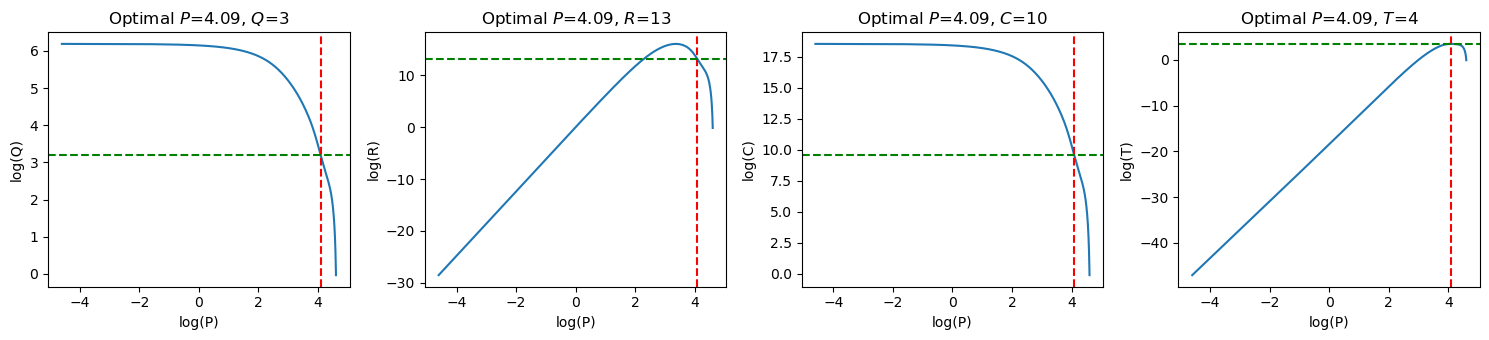

In [54]:
fig, ax = plt.subplots(1, 4, figsize=(15, 3.5))

for y, _ax in zip(['Q', 'R', 'C', 'T'], ax):
    _df.plot(kind='line', x='P', y=y, ax=_ax)
    _ax.axvline(x=opt_s['P'], color='r', linestyle='--')
    _ax.axhline(y=opt_s[y], color='g', linestyle='--')
    _ax.set_ylabel(f'log({y})')
    _ax.set_xlabel(f'log(P)')
    _ax.set_title(rf'Optimal $P$={opt_s["P"]:.2f}, ${y}$={opt_s[y]:,.0f}')
    _ax.legend().remove()

fig.tight_layout()

<Axes: xlabel='Q'>

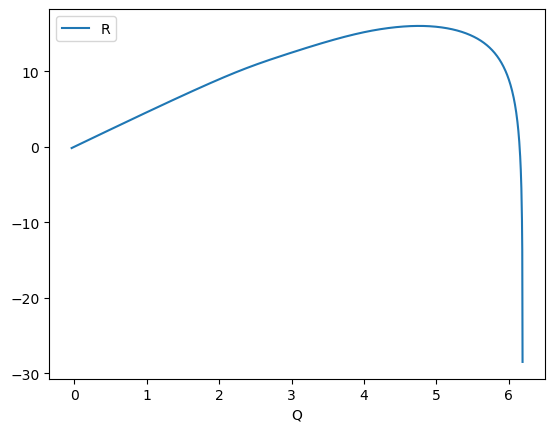

In [72]:
_df.plot(kind='line', x='Q', y='R')